# Retail Purchase Prediction and Responsible Optimization Project
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


## Project Overview
This project focuses on predicting individual customer purchases in a retail store using a dataset of 550,069 transactions and 12 attributes. The primary objective is to construct an accurate, interpretable regression model for predicting purchase amounts (`Purchase`) and to leverage these predictions to optimize business operations such as inventory allocation and promotional strategies.  

The project also emphasizes **regulatory compliance, fairness, and transparency**, ensuring that the predictive system meets industry standards for explainability and ethical usage of sensitive data.

## Methodology

1. **Data Governance & Risk Assessment**
   - Evaluate sensitive attributes (`Gender`, `Age`) and ensure they are excluded from modeling while used for monitoring fairness.
   - Implement data lineage, reproducibility, and retention policies.
   - Ensure dataset de-identification and PII minimization.

2. **Data Preprocessing**
   - Handle missing values and masked columns safely.
   - Convert data types to appropriate categorical or numerical forms.
   - Encode features while avoiding leakage (e.g., target encoding only within training folds).
   - Winsorize or handle outliers in purchase values.

3. **Feature Engineering**
   - Create high-signal features such as user/product transaction counts, diversity, and interaction terms.
   - Generate target-encoded features using leakage-safe K-Fold schemes.
   - Include historical purchase statistics and proxies for recency/fatigue.
   - Ensure all transformations are reproducible through pipelines.

4. **Modeling**
   - **Primary Model:** Explainable Boosting Machine (EBM) for transparency.
   - **Challenger Model:** CatBoost Regressor for high accuracy.
   - Optimize for MAE with hyperparameter tuning using Grouped Cross-Validation.
   - Apply conformal prediction to produce reliable prediction intervals.

5. **Validation & Evaluation**
   - Use GroupKFold CV by `User_ID` and `Product_ID` to prevent leakage.
   - Report MAE, RMSE, and R-squared overall and by sensitive subgroups.
   - Evaluate prediction intervals and subgroup fairness.

6. **Interpretability & Transparency**
   - Global explanations: EBM term plots, permutation importance, PDP/ICE.
   - Local explanations: SHAP values or EBM additive terms for each prediction.
   - Documentation via model card and feature dictionary.

7. **Innovative Business Application**
   - Responsible Promotion & Inventory Optimizer (RPIO) using predicted purchases.
   - Objective: maximize margin while minimizing stockouts and ensuring fair promotions.
   - Outputs: city-level inventory allocation and user-level promotion recommendations with explanations.

8. **Deployment & Monitoring**
   - Feature store, MLOps pipeline, and model registry with version control.
   - Real-time API for predictions and explanations.
   - Batch optimization jobs for weekly inventory/promo planning.
   - Continuous monitoring of performance, prediction intervals, and fairness metrics.

## Deliverables
- Accurate and interpretable purchase prediction model.
- Conformal prediction intervals for each prediction.
- Detailed fairness and bias report.
- Responsible optimization framework for inventory and promotion.
- Full reproducibility and documentation in line with industry standards.

This notebook will implement the above methodology step-by-step, ensuring reproducibility, transparency, and business impact.


In [1]:
# Data Handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & Feature Engineering
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GroupKFold, train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from category_encoders import TargetEncoder

# Modeling
from interpret.glassbox import ExplainableBoostingRegressor
from catboost import CatBoostRegressor, Pool

# Utilities
import warnings
warnings.filterwarnings("ignore")
import os
import random

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Libraries imported successfully!")


Libraries imported successfully!


Dataset Shape: (550068, 12)

First 5 rows of the dataset:


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969



Data Types and Missing Values:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memor

None


Summary Statistics for Numerical Columns:


,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000



Missing Values per Column:


User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
Purchase                           0
dtype: int64

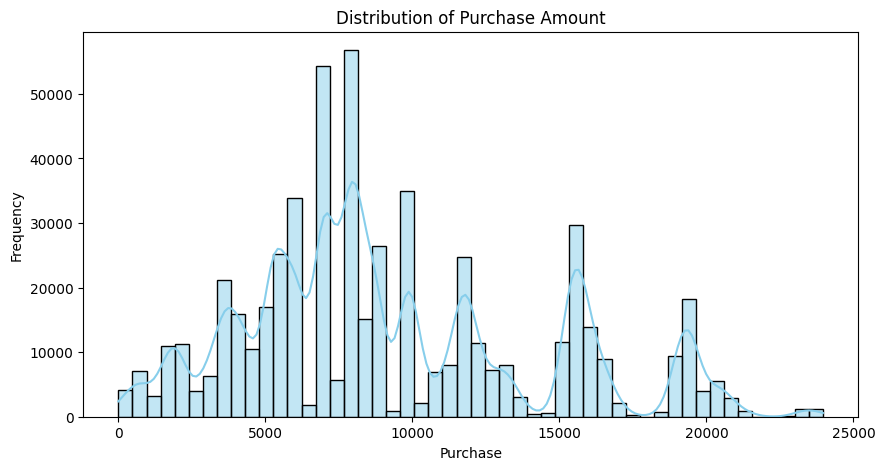

In [2]:
# Load Dataset
df = pd.read_csv("train.csv")

# Initial Exploration
# 1. Dataset shape
print(f"Dataset Shape: {df.shape}\n")

# 2. First 5 rows
print("First 5 rows of the dataset:")
display(df.head())

# 3. Data types and missing values
print("\nData Types and Missing Values:")
display(df.info())

# 4. Summary statistics for numerical columns
print("\nSummary Statistics for Numerical Columns:")
display(df.describe())

# 5. Check for missing values
print("\nMissing Values per Column:")
display(df.isnull().sum())

# 6. Basic distribution of target variable
plt.figure(figsize=(10,5))
sns.histplot(df['Purchase'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Purchase Amount")
plt.xlabel("Purchase")
plt.ylabel("Frequency")
plt.show()


In [3]:
# Data Preprocessing
df_processed = df.copy()

# 1. Convert 'Stay_In_Current_City_Years' from object to int
# Replace '4+' with 4 and convert to integer
df_processed['Stay_In_Current_City_Years'] = df_processed['Stay_In_Current_City_Years'].replace({'4+': 4}).astype(int)

# 2. Encode 'Age' as ordinal integers
age_mapping = {'0-17': 0, '18-25': 1, '26-35': 2, '36-45': 3, '46-50': 4, '51-55': 5, '55+': 6}
df_processed['Age'] = df_processed['Age'].map(age_mapping)

# 3. Handle missing values in Product_Category_2 and Product_Category_3
for col in ['Product_Category_2', 'Product_Category_3']:
    df_processed[f'{col}_missing'] = df_processed[col].isnull().astype(int)  # Missing indicator
    df_processed[col] = df_processed[col].fillna(-1).astype(int)  # Impute with -1

# 4. Convert categorical columns to type 'category'
categorical_cols = ['Gender', 'City_Category', 'Marital_Status', 'Occupation', 
                    'Product_Category_1', 'Product_Category_2', 'Product_Category_3']
df_processed[categorical_cols] = df_processed[categorical_cols].astype('category')

# 5. Verify preprocessing
print("Data types after preprocessing:")
display(df_processed.dtypes)

print("\nMissing values after preprocessing:")
display(df_processed.isnull().sum())

print("\nFirst 5 rows after preprocessing:")
display(df_processed.head())


Data types after preprocessing:


User_ID                          int64
Product_ID                      object
Gender                        category
Age                              int64
Occupation                    category
City_Category                 category
Stay_In_Current_City_Years       int64
Marital_Status                category
Product_Category_1            category
Product_Category_2            category
Product_Category_3            category
Purchase                         int64
Product_Category_2_missing       int64
Product_Category_3_missing       int64
dtype: object


Missing values after preprocessing:


User_ID                       0
Product_ID                    0
Gender                        0
Age                           0
Occupation                    0
City_Category                 0
Stay_In_Current_City_Years    0
Marital_Status                0
Product_Category_1            0
Product_Category_2            0
Product_Category_3            0
Purchase                      0
Product_Category_2_missing    0
Product_Category_3_missing    0
dtype: int64


First 5 rows after preprocessing:


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,Product_Category_2_missing,Product_Category_3_missing
0,1000001,P00069042,F,0,10,A,2,0,3,-1,-1,8370,1,1
1,1000001,P00248942,F,0,10,A,2,0,1,6,14,15200,0,0
2,1000001,P00087842,F,0,10,A,2,0,12,-1,-1,1422,1,1
3,1000001,P00085442,F,0,10,A,2,0,12,14,-1,1057,0,1
4,1000002,P00285442,M,6,16,C,4,0,8,-1,-1,7969,1,1


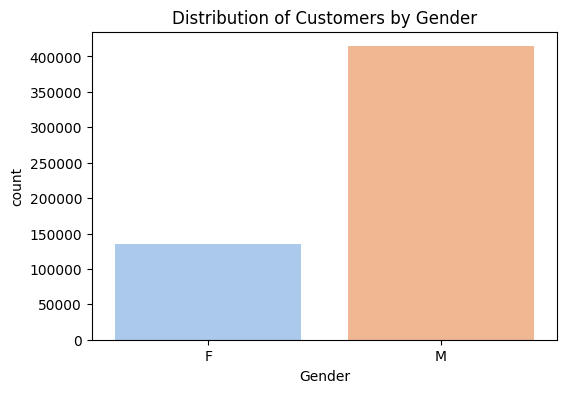

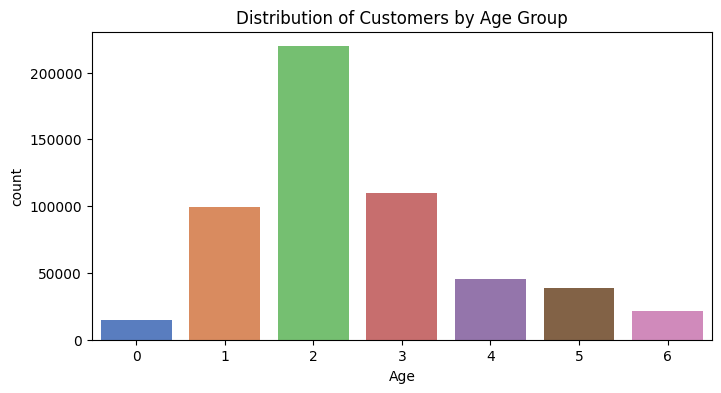

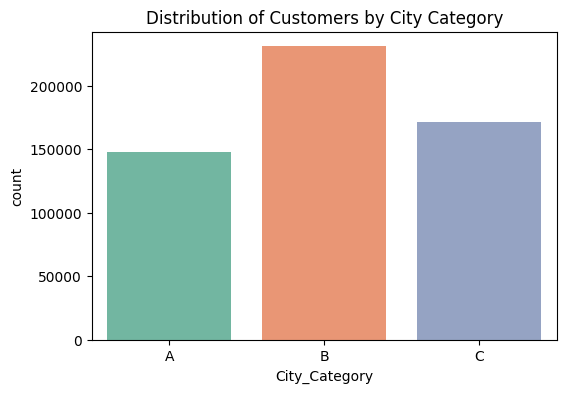

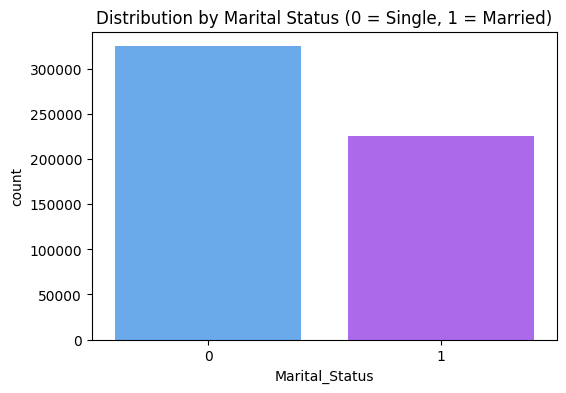

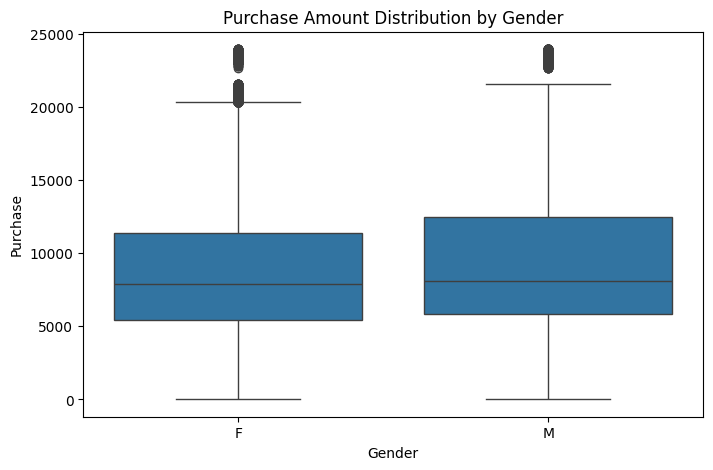

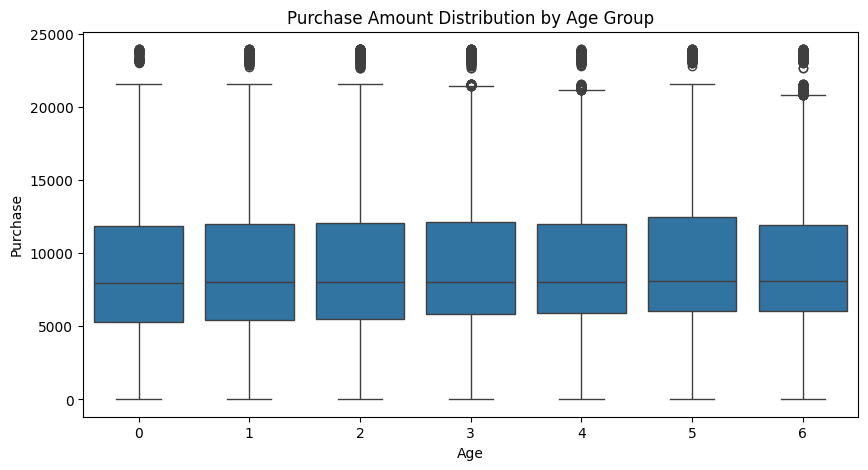

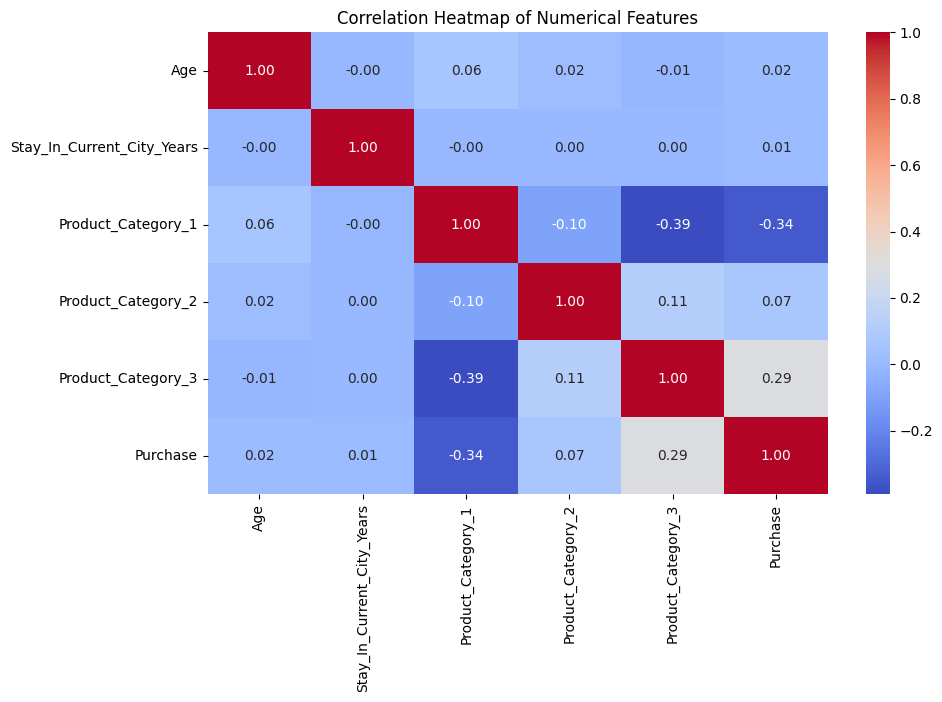

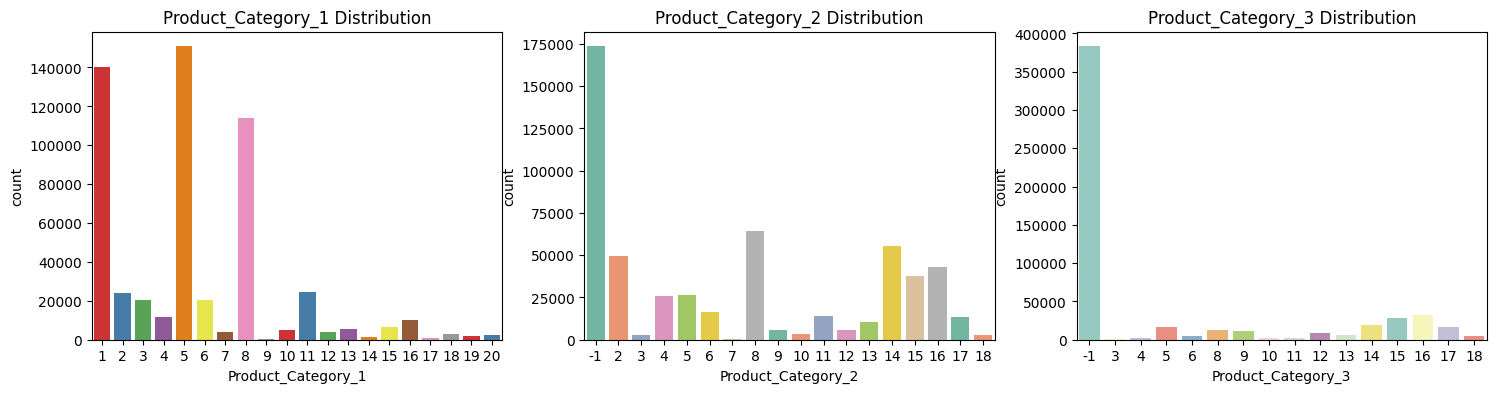

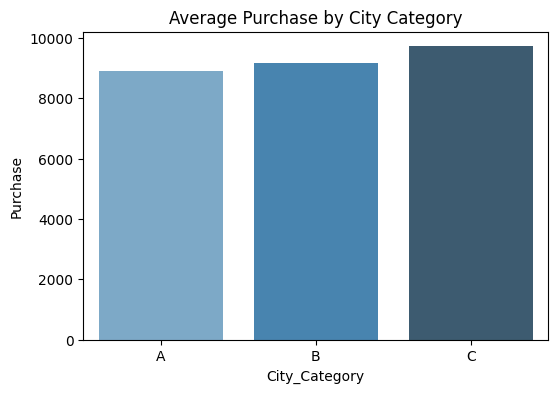

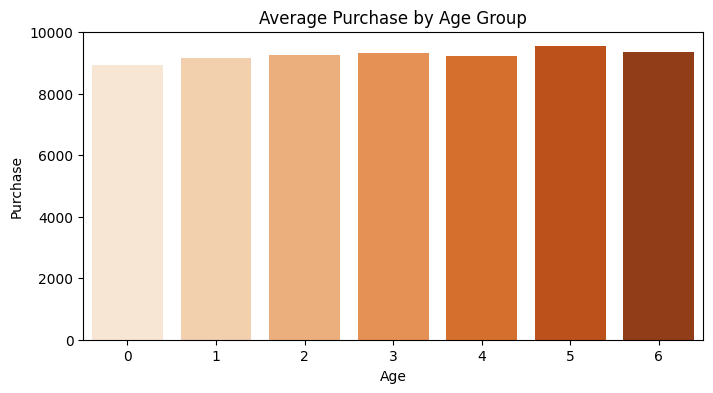

In [4]:
# Exploratory Data Analysis (EDA)

# 1. Gender Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Gender', data=df_processed, palette='pastel')
plt.title("Distribution of Customers by Gender")
plt.show()

# 2. Age Distribution
plt.figure(figsize=(8,4))
sns.countplot(x='Age', data=df_processed, palette='muted')
plt.title("Distribution of Customers by Age Group")
plt.show()

# 3. City Category Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='City_Category', data=df_processed, palette='Set2')
plt.title("Distribution of Customers by City Category")
plt.show()

# 4. Marital Status Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Marital_Status', data=df_processed, palette='cool')
plt.title("Distribution by Marital Status (0 = Single, 1 = Married)")
plt.show()

# 5. Purchase Distribution by Gender
plt.figure(figsize=(8,5))
sns.boxplot(x='Gender', y='Purchase', data=df_processed)
plt.title("Purchase Amount Distribution by Gender")
plt.show()

# 6. Purchase Distribution by Age Group
plt.figure(figsize=(10,5))
sns.boxplot(x='Age', y='Purchase', data=df_processed)
plt.title("Purchase Amount Distribution by Age Group")
plt.show()

# 7. Correlation Heatmap for numerical variables
numerical_cols = ['Age', 'Stay_In_Current_City_Years', 'Product_Category_1',
                  'Product_Category_2', 'Product_Category_3', 'Purchase']
plt.figure(figsize=(10,6))
sns.heatmap(df_processed[numerical_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

# 8. Product Category Distribution
fig, axes = plt.subplots(1, 3, figsize=(18,4))
sns.countplot(x='Product_Category_1', data=df_processed, ax=axes[0], palette='Set1')
axes[0].set_title("Product_Category_1 Distribution")
sns.countplot(x='Product_Category_2', data=df_processed, ax=axes[1], palette='Set2')
axes[1].set_title("Product_Category_2 Distribution")
sns.countplot(x='Product_Category_3', data=df_processed, ax=axes[2], palette='Set3')
axes[2].set_title("Product_Category_3 Distribution")
plt.show()

# 9. Average Purchase by City Category
city_purchase = df_processed.groupby('City_Category')['Purchase'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(x='City_Category', y='Purchase', data=city_purchase, palette='Blues_d')
plt.title("Average Purchase by City Category")
plt.show()

# 10. Average Purchase by Age Group
age_purchase = df_processed.groupby('Age')['Purchase'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='Age', y='Purchase', data=age_purchase, palette='Oranges')
plt.title("Average Purchase by Age Group")
plt.show()


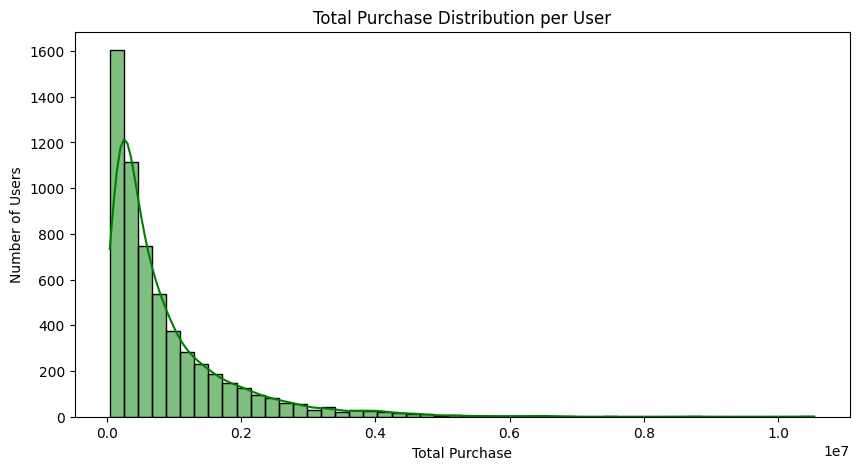

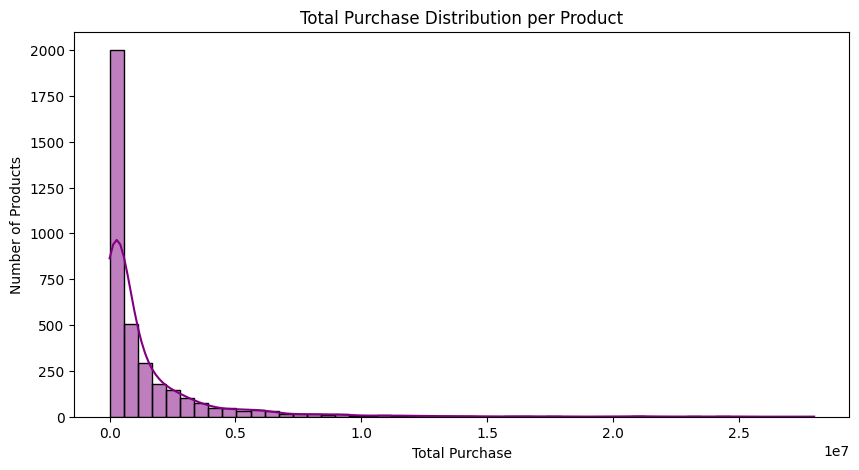

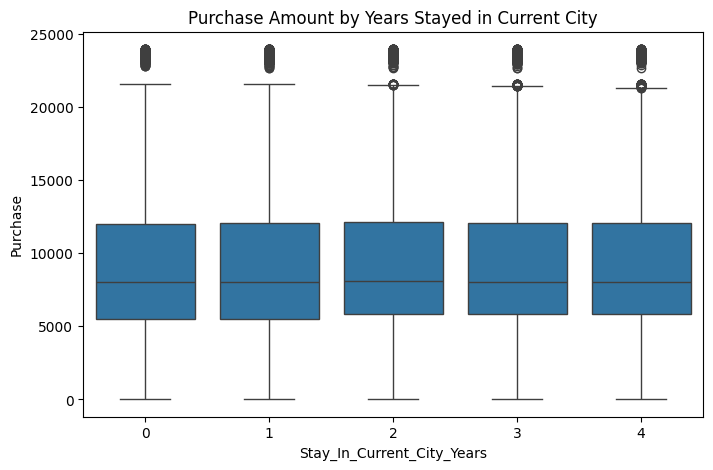

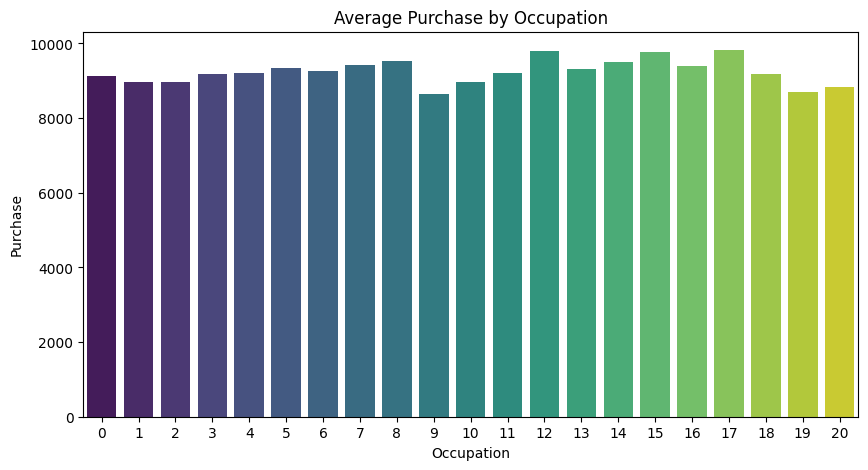

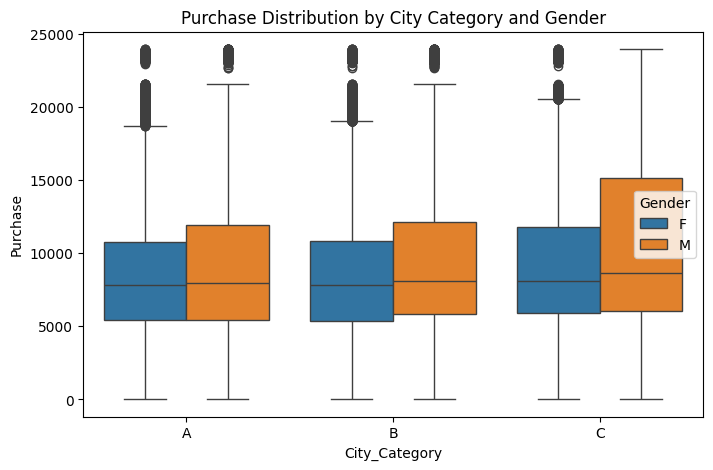

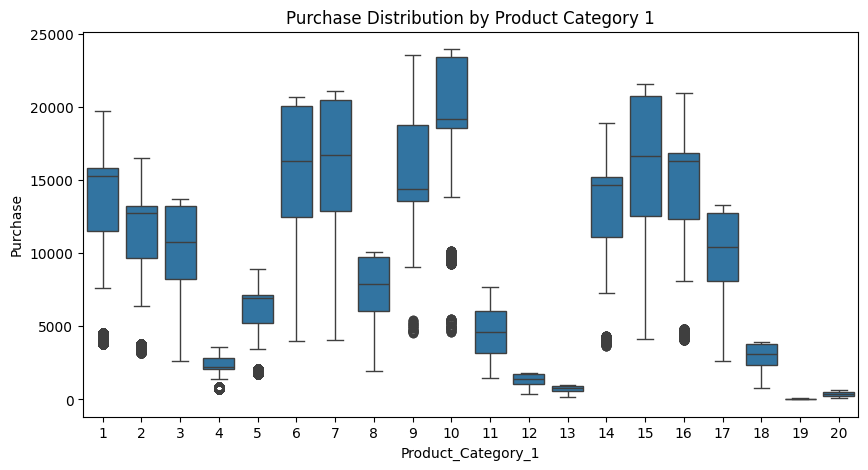

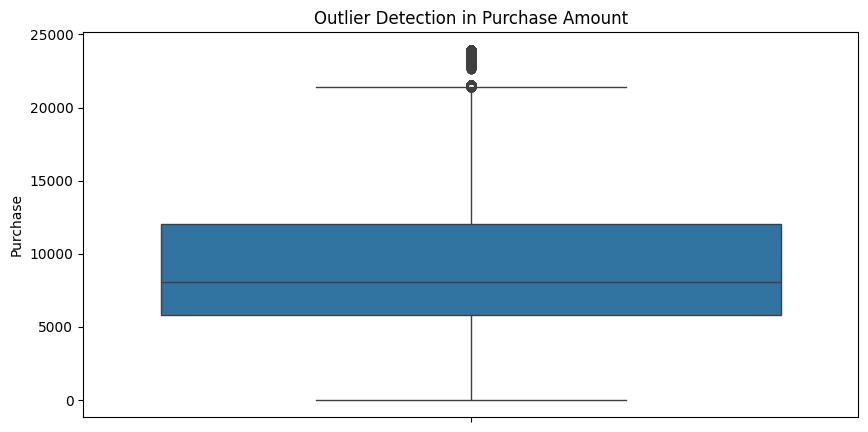

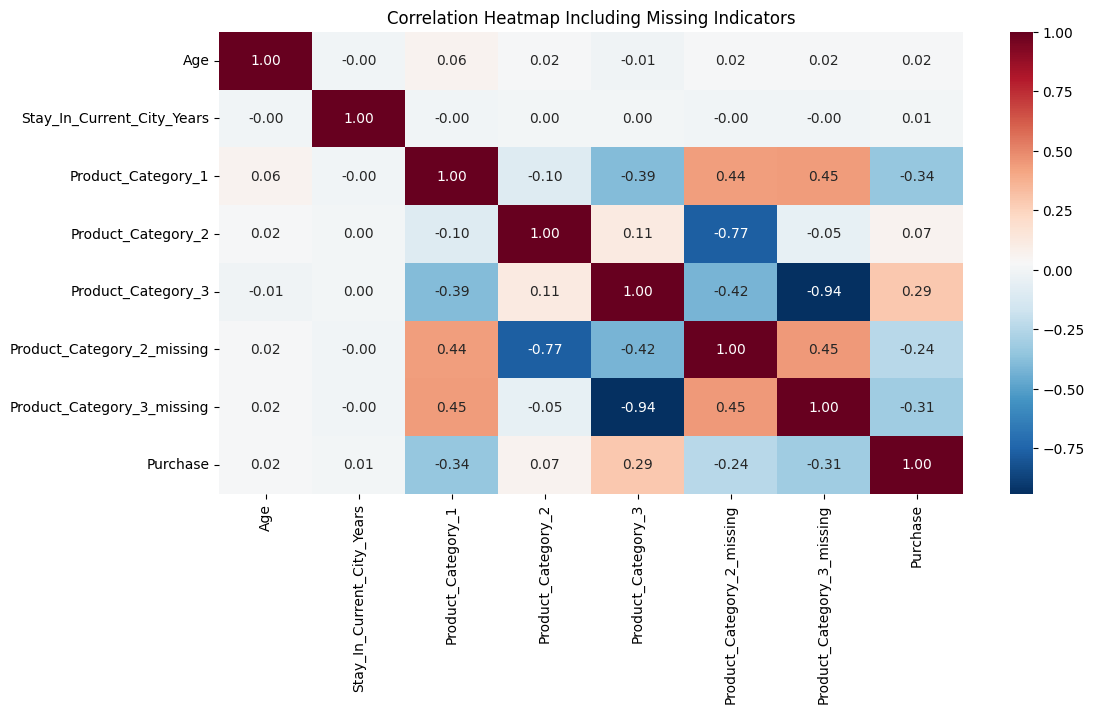

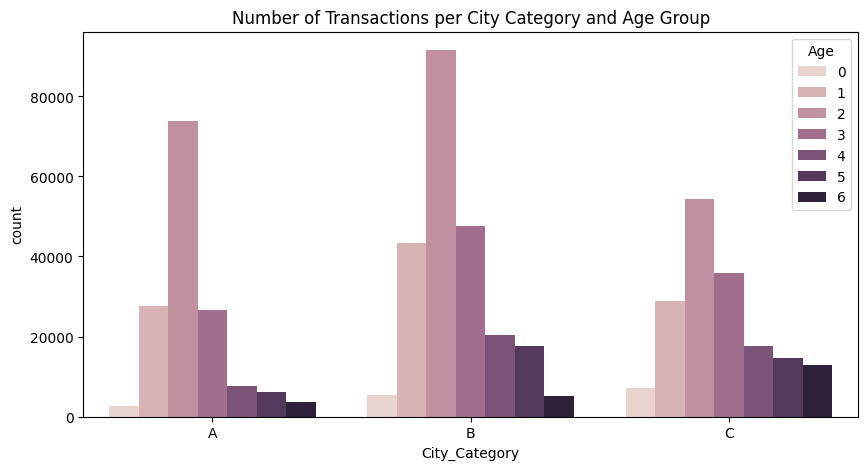

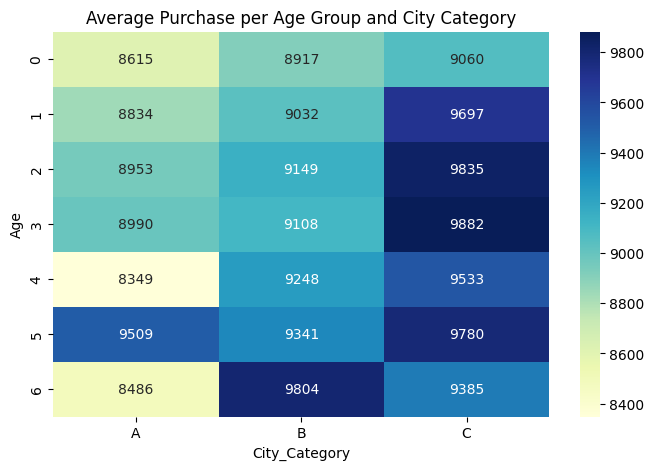

In [5]:
# Comprehensive EDA

# 1. Users vs Total Purchase
user_purchase = df_processed.groupby('User_ID')['Purchase'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.histplot(user_purchase, bins=50, kde=True, color='green')
plt.title("Total Purchase Distribution per User")
plt.xlabel("Total Purchase")
plt.ylabel("Number of Users")
plt.show()

# 2. Products vs Total Purchase
product_purchase = df_processed.groupby('Product_ID')['Purchase'].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
sns.histplot(product_purchase, bins=50, kde=True, color='purple')
plt.title("Total Purchase Distribution per Product")
plt.xlabel("Total Purchase")
plt.ylabel("Number of Products")
plt.show()

# 3. Purchase vs Stay_In_Current_City_Years
plt.figure(figsize=(8,5))
sns.boxplot(x='Stay_In_Current_City_Years', y='Purchase', data=df_processed)
plt.title("Purchase Amount by Years Stayed in Current City")
plt.show()

# 4. Occupation vs Average Purchase
occupation_purchase = df_processed.groupby('Occupation')['Purchase'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.barplot(x='Occupation', y='Purchase', data=occupation_purchase, palette='viridis')
plt.title("Average Purchase by Occupation")
plt.show()

# 5. Interaction: Gender × City_Category vs Purchase
plt.figure(figsize=(8,5))
sns.boxplot(x='City_Category', y='Purchase', hue='Gender', data=df_processed)
plt.title("Purchase Distribution by City Category and Gender")
plt.show()

# 6. Product_Category_1 vs Purchase
plt.figure(figsize=(10,5))
sns.boxplot(x='Product_Category_1', y='Purchase', data=df_processed)
plt.title("Purchase Distribution by Product Category 1")
plt.show()

# 7. Check for outliers in Purchase
plt.figure(figsize=(10,5))
sns.boxplot(y='Purchase', data=df_processed)
plt.title("Outlier Detection in Purchase Amount")
plt.show()

# 8. Correlation Heatmap for all numeric columns including missing indicators
numeric_cols = ['Age', 'Stay_In_Current_City_Years', 'Product_Category_1', 
                'Product_Category_2', 'Product_Category_3', 
                'Product_Category_2_missing', 'Product_Category_3_missing', 'Purchase']
plt.figure(figsize=(12,6))
sns.heatmap(df_processed[numeric_cols].corr(), annot=True, fmt=".2f", cmap="RdBu_r")
plt.title("Correlation Heatmap Including Missing Indicators")
plt.show()

# 9. Count of transactions per City_Category and Age
plt.figure(figsize=(10,5))
sns.countplot(x='City_Category', hue='Age', data=df_processed)
plt.title("Number of Transactions per City Category and Age Group")
plt.show()

# 10. Average Purchase per Age × City_Category
age_city_purchase = df_processed.groupby(['Age','City_Category'])['Purchase'].mean().unstack()
plt.figure(figsize=(8,5))
sns.heatmap(age_city_purchase, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Average Purchase per Age Group and City Category")
plt.show()


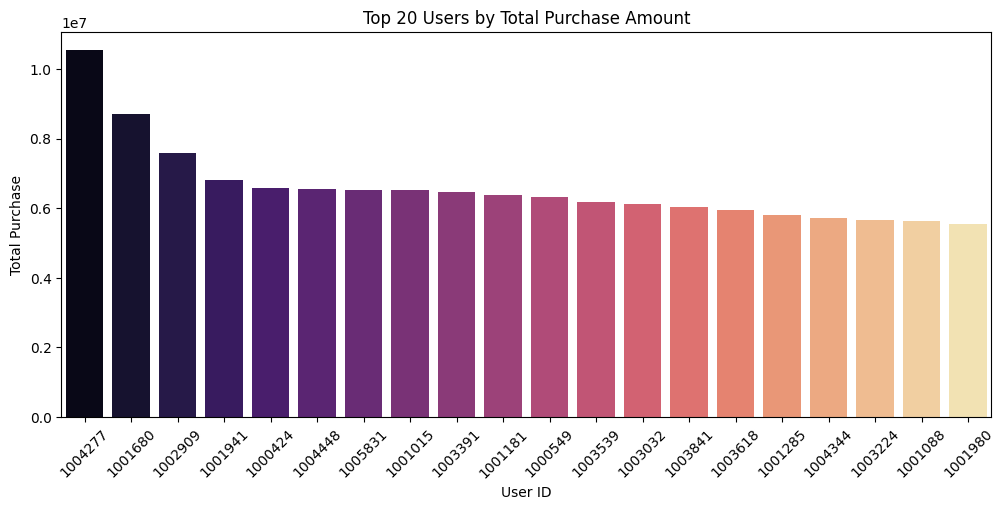

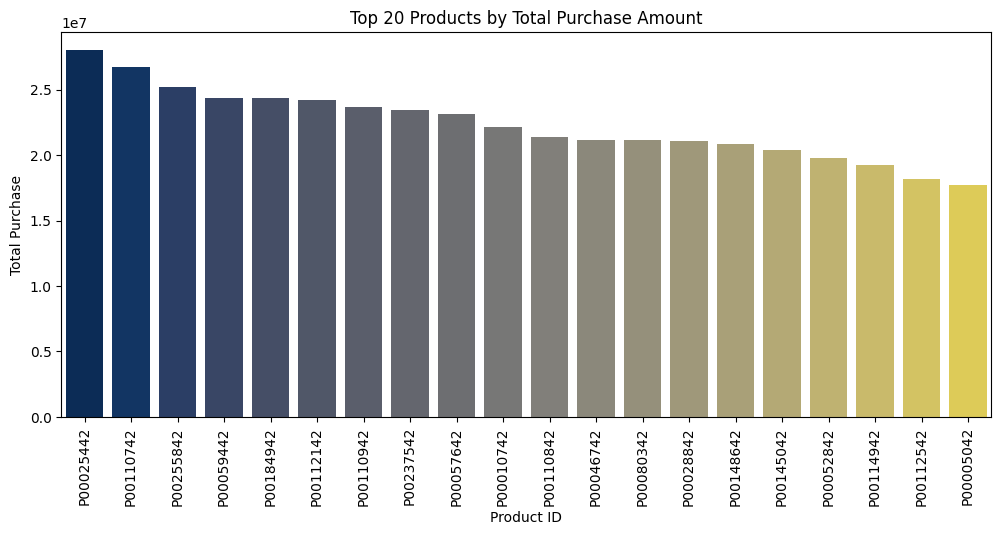

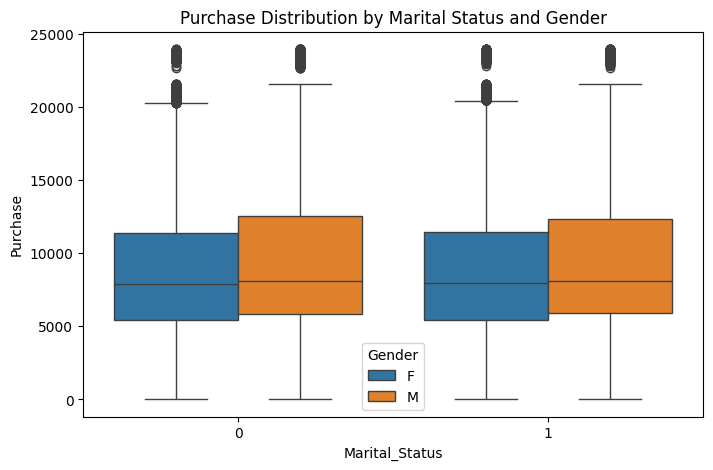

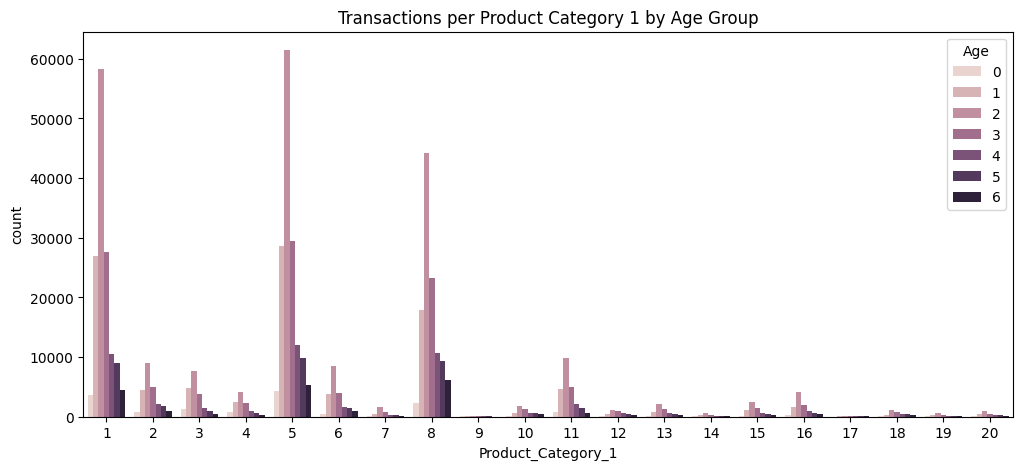

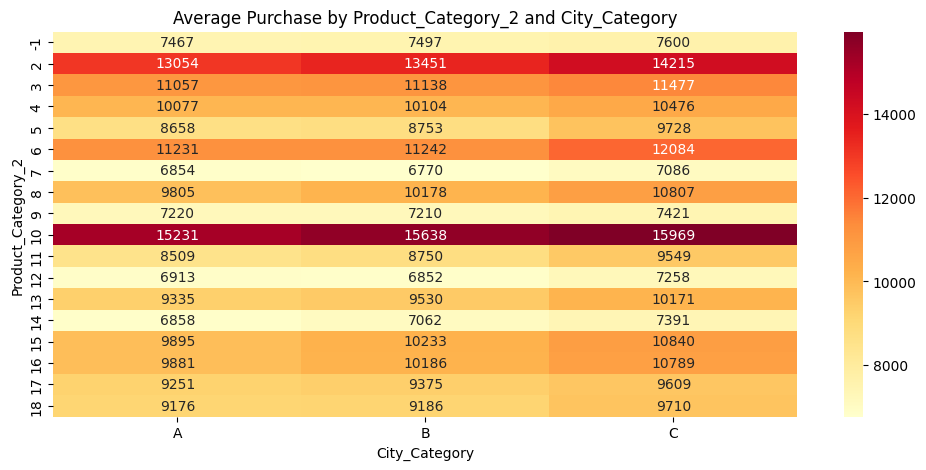

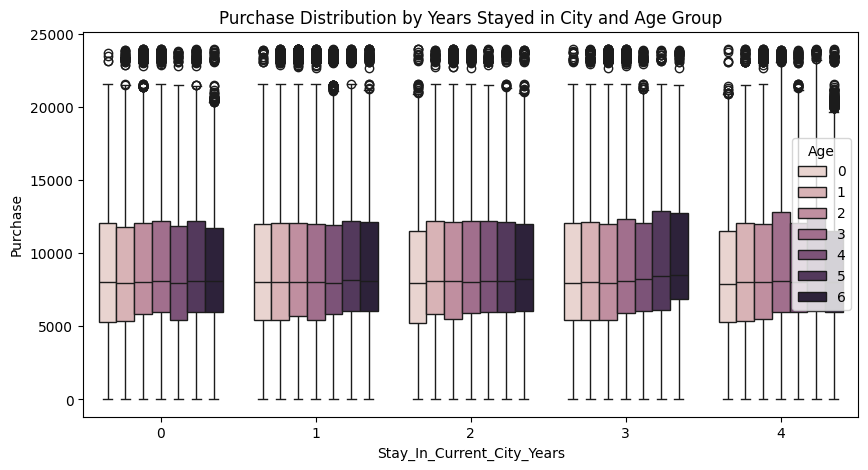

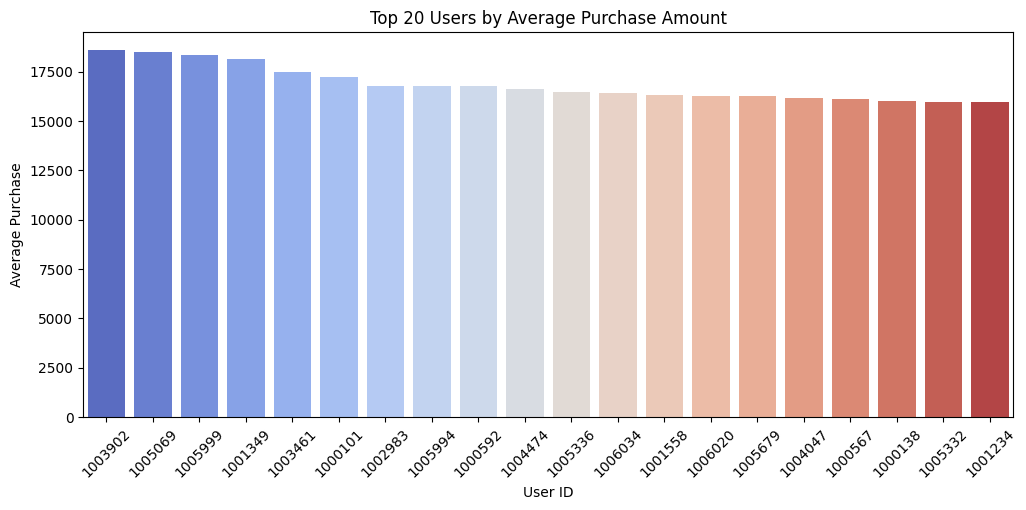

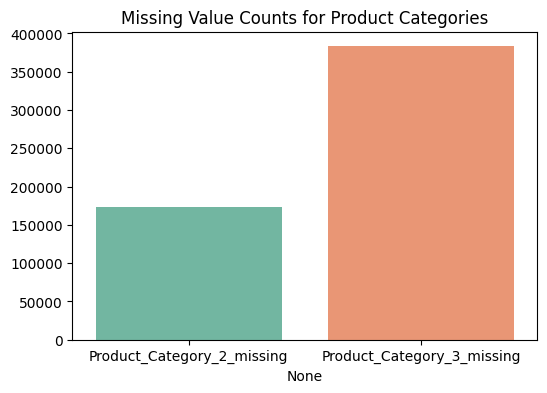

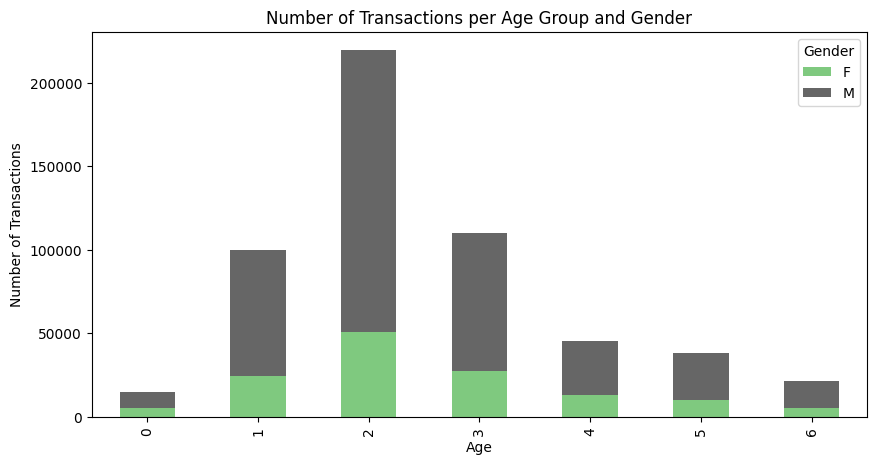

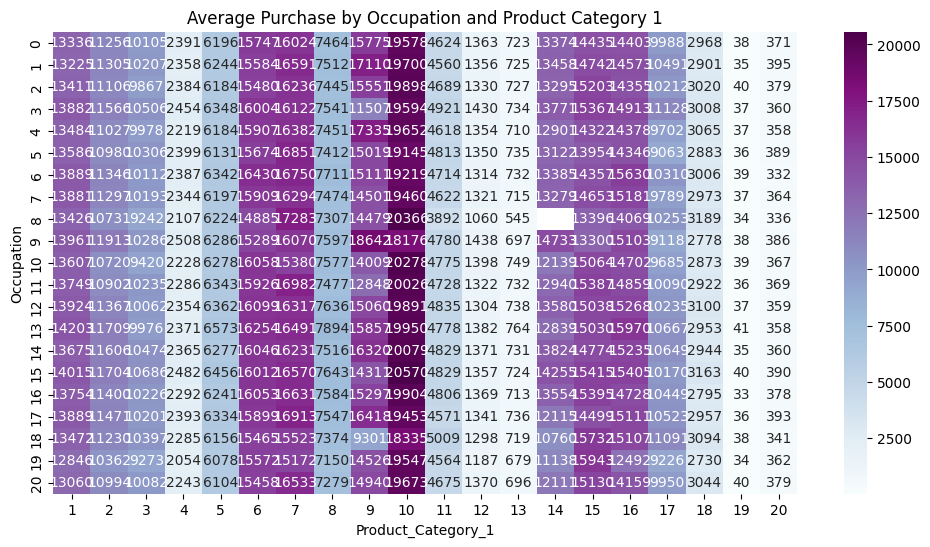

In [6]:
# Advanced EDA: User, Product, and Interaction Analysis

# 1. Top 20 users by total purchase
top_users = df_processed.groupby('User_ID')['Purchase'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=top_users.index.astype(str), y=top_users.values, palette='magma')
plt.xticks(rotation=45)
plt.title("Top 20 Users by Total Purchase Amount")
plt.ylabel("Total Purchase")
plt.xlabel("User ID")
plt.show()

# 2. Top 20 products by total purchase
top_products = df_processed.groupby('Product_ID')['Purchase'].sum().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=top_products.index, y=top_products.values, palette='cividis')
plt.xticks(rotation=90)
plt.title("Top 20 Products by Total Purchase Amount")
plt.ylabel("Total Purchase")
plt.xlabel("Product ID")
plt.show()

# 3. Purchase trends by Marital Status and Gender
plt.figure(figsize=(8,5))
sns.boxplot(x='Marital_Status', y='Purchase', hue='Gender', data=df_processed)
plt.title("Purchase Distribution by Marital Status and Gender")
plt.show()

# 4. Number of transactions per Product_Category_1 vs Age group
plt.figure(figsize=(12,5))
sns.countplot(x='Product_Category_1', hue='Age', data=df_processed)
plt.title("Transactions per Product Category 1 by Age Group")
plt.show()

# 5. Average purchase per Product_Category_2 vs City_Category
cat2_city_purchase = df_processed.groupby(['Product_Category_2','City_Category'])['Purchase'].mean().unstack()
plt.figure(figsize=(12,5))
sns.heatmap(cat2_city_purchase, annot=True, fmt=".0f", cmap='YlOrRd')
plt.title("Average Purchase by Product_Category_2 and City_Category")
plt.show()

# 6. Purchase distribution by Stay_In_Current_City_Years and Age
plt.figure(figsize=(10,5))
sns.boxplot(x='Stay_In_Current_City_Years', y='Purchase', hue='Age', data=df_processed)
plt.title("Purchase Distribution by Years Stayed in City and Age Group")
plt.show()

# 7. Users with highest average purchase
user_avg_purchase = df_processed.groupby('User_ID')['Purchase'].mean().sort_values(ascending=False).head(20)
plt.figure(figsize=(12,5))
sns.barplot(x=user_avg_purchase.index.astype(str), y=user_avg_purchase.values, palette='coolwarm')
plt.xticks(rotation=45)
plt.title("Top 20 Users by Average Purchase Amount")
plt.ylabel("Average Purchase")
plt.xlabel("User ID")
plt.show()

# 8. Distribution of missing values in Product_Category_2 and Product_Category_3
missing_counts = df_processed[['Product_Category_2_missing','Product_Category_3_missing']].sum()
plt.figure(figsize=(6,4))
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='Set2')
plt.title("Missing Value Counts for Product Categories")
plt.show()

# 9. Cross-tab: Age × Gender for transaction counts
age_gender_counts = pd.crosstab(df_processed['Age'], df_processed['Gender'])
age_gender_counts.plot(kind='bar', stacked=True, figsize=(10,5), colormap='Accent')
plt.title("Number of Transactions per Age Group and Gender")
plt.ylabel("Number of Transactions")
plt.show()

# 10. Average purchase per Occupation × Product_Category_1
occ_prod_purchase = df_processed.groupby(['Occupation','Product_Category_1'])['Purchase'].mean().unstack()
plt.figure(figsize=(12,6))
sns.heatmap(occ_prod_purchase, annot=True, fmt=".0f", cmap='BuPu')
plt.title("Average Purchase by Occupation and Product Category 1")
plt.show()


In [7]:
# Feature Engineering
df_features = df_processed.copy()

# 1. User-level features
user_stats = df_features.groupby('User_ID')['Purchase'].agg(['count', 'mean', 'sum']).reset_index()
user_stats.columns = ['User_ID', 'user_txn_count', 'user_avg_purchase', 'user_total_purchase']
df_features = df_features.merge(user_stats, on='User_ID', how='left')

# 2. Product-level features
product_stats = df_features.groupby('Product_ID')['Purchase'].agg(['count', 'mean']).reset_index()
product_stats.columns = ['Product_ID', 'product_buyer_count', 'product_avg_purchase']
df_features = df_features.merge(product_stats, on='Product_ID', how='left')

# 3. Interaction features
# City × Product_Category_1
df_features['City_ProductCat1'] = df_features['City_Category'].astype(str) + "_" + df_features['Product_Category_1'].astype(str)

# Occupation × Product_Category_1
df_features['Occupation_ProductCat1'] = df_features['Occupation'].astype(str) + "_" + df_features['Product_Category_1'].astype(str)

# 4. Frequency encoding for high-cardinality columns
# Product_ID frequency
prod_freq = df_features['Product_ID'].value_counts().to_dict()
df_features['Product_ID_freq'] = df_features['Product_ID'].map(prod_freq)

# User_ID frequency
user_freq = df_features['User_ID'].value_counts().to_dict()
df_features['User_ID_freq'] = df_features['User_ID'].map(user_freq)

# 5. Drop columns not used for modeling directly
# Keep ID columns separate if needed for group-based CV
model_cols = df_features.drop(columns=['User_ID', 'Product_ID']).columns

# 6. Convert new categorical interaction features to category type
df_features['City_ProductCat1'] = df_features['City_ProductCat1'].astype('category')
df_features['Occupation_ProductCat1'] = df_features['Occupation_ProductCat1'].astype('category')

# 7. Verify feature engineering
print("Feature engineering completed. Sample of engineered features:")
display(df_features.head())


Feature engineering completed. Sample of engineered features:


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,...,Product_Category_3_missing,user_txn_count,user_avg_purchase,user_total_purchase,product_buyer_count,product_avg_purchase,City_ProductCat1,Occupation_ProductCat1,Product_ID_freq,User_ID_freq
0,1000001,P00069042,F,0,10,A,2,0,3,-1,...,1,35,9545.514286,334093,227,11870.863436,A_3,10_3,227,35
1,1000001,P00248942,F,0,10,A,2,0,1,6,...,0,35,9545.514286,334093,581,16304.030981,A_1,10_1,581,35
2,1000001,P00087842,F,0,10,A,2,0,12,-1,...,1,35,9545.514286,334093,102,1237.892157,A_12,10_12,102,35
3,1000001,P00085442,F,0,10,A,2,0,12,14,...,1,35,9545.514286,334093,341,1455.140762,A_12,10_12,341,35
4,1000002,P00285442,M,6,16,C,4,0,8,-1,...,1,77,10525.610390,810472,203,7692.763547,C_8,16_8,203,77


In [14]:
# After creating engineered features like City_ProductCat1, Occupation_ProductCat1
from sklearn.preprocessing import LabelEncoder
import joblib

# Encode City_ProductCat1
city_prod_encoder = LabelEncoder()
df_features['City_ProductCat1_enc'] = city_prod_encoder.fit_transform(df_features['City_ProductCat1'])
# Save the encoder for later use in the app
joblib.dump(city_prod_encoder, "city_prod_encoder.pkl")

# Encode Occupation_ProductCat1
occ_prod_encoder = LabelEncoder()
df_features['Occupation_ProductCat1_enc'] = occ_prod_encoder.fit_transform(df_features['Occupation_ProductCat1'])
# Save the encoder for later use in the app
joblib.dump(occ_prod_encoder, "occ_prod_encoder.pkl")


['occ_prod_encoder.pkl']

In [15]:
from sklearn.preprocessing import LabelEncoder
import joblib

# Encode City_ProductCat1
city_prod_encoder = LabelEncoder()
df_features['City_ProductCat1_enc'] = city_prod_encoder.fit_transform(df_features['City_ProductCat1'])

# Save the encoder
joblib.dump(city_prod_encoder, "city_prod_encoder.pkl")


['city_prod_encoder.pkl']

In [8]:
# Data Preparation for Modeling
from sklearn.model_selection import train_test_split

# 1. Define target and features
target = 'Purchase'
features = df_features.drop(columns=['User_ID', 'Product_ID', 'Purchase'])

X = features
y = df_features[target]

# 2. Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# 3. Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(['category']).columns.tolist()
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Categorical features: {categorical_features}")
print(f"Numerical features: {numerical_features}")

# 4. Preprocessing pipelines
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Numerical pipeline: scale numerical features
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categorical pipeline: one-hot encode categorical features
cat_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features)
])


Training set shape: (440054, 20)
Testing set shape: (110014, 20)
Categorical features: ['Gender', 'Occupation', 'City_Category', 'Marital_Status', 'Product_Category_1', 'Product_Category_2', 'Product_Category_3', 'City_ProductCat1', 'Occupation_ProductCat1']
Numerical features: ['Age', 'Stay_In_Current_City_Years', 'Product_Category_2_missing', 'Product_Category_3_missing', 'user_txn_count', 'user_avg_purchase', 'user_total_purchase', 'product_buyer_count', 'product_avg_purchase', 'Product_ID_freq', 'User_ID_freq']


In [16]:
# Optimized Model Training and Evaluation (Subset)
from interpret.glassbox import ExplainableBoostingRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import joblib
from sklearn.preprocessing import LabelEncoder

# 1. Subsample the dataset for faster training
train_sample_size = 50000
test_sample_size = 20000
X_train_sample = X_train.sample(train_sample_size, random_state=SEED)
y_train_sample = y_train.loc[X_train_sample.index]
X_test_sample = X_test.sample(test_sample_size, random_state=SEED)
y_test_sample = y_test.loc[X_test_sample.index]

print(f"Training sample shape: {X_train_sample.shape}")
print(f"Testing sample shape: {X_test_sample.shape}")

# 2. EBM Model Pipeline
ebm_model = ExplainableBoostingRegressor(
    random_state=SEED,
    max_bins=88,      # reduce number of bins
    max_rounds=70     # reduce boosting rounds
)

ebm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ebm_model)
])

print("Training Explainable Boosting Regressor on subset...")
ebm_pipeline.fit(X_train_sample, y_train_sample)

# Predictions & Evaluation
y_pred_ebm = ebm_pipeline.predict(X_test_sample)
mae_ebm = mean_absolute_error(y_test_sample, y_pred_ebm)
rmse_ebm = np.sqrt(mean_squared_error(y_test_sample, y_pred_ebm))  # corrected for older sklearn
r2_ebm = r2_score(y_test_sample, y_pred_ebm)
print(f"EBM Performance on subset:\nMAE: {mae_ebm:.2f}\nRMSE: {rmse_ebm:.2f}\nR2 Score: {r2_ebm:.4f}")

# 3. Encode combined categorical features for CatBoost
city_prod_encoder = joblib.load("city_prod_encoder.pkl")
occ_prod_encoder = joblib.load("occ_prod_encoder.pkl")

X_train_sample['City_ProductCat1'] = city_prod_encoder.transform(X_train_sample['City_ProductCat1'])
X_train_sample['Occupation_ProductCat1'] = occ_prod_encoder.transform(X_train_sample['Occupation_ProductCat1'])
X_test_sample['City_ProductCat1'] = city_prod_encoder.transform(X_test_sample['City_ProductCat1'])
X_test_sample['Occupation_ProductCat1'] = occ_prod_encoder.transform(X_test_sample['Occupation_ProductCat1'])

# 4. CatBoost Model Pipeline
cat_features_indices = [X_train_sample.columns.get_loc(col) for col in categorical_features if col not in ['City_ProductCat1','Occupation_ProductCat1']]

cat_model = CatBoostRegressor(
    iterations=100,    # reduced from 1000
    learning_rate=0.1,
    depth=6,
    eval_metric='MAE',
    random_seed=SEED,
    verbose=50
)

print("\nTraining CatBoost Regressor on subset...")
cat_model.fit(
    X_train_sample, y_train_sample,
    cat_features=cat_features_indices,
    eval_set=(X_test_sample, y_test_sample)
)

# Predictions & Evaluation
y_pred_cat = cat_model.predict(X_test_sample)
mae_cat = mean_absolute_error(y_test_sample, y_pred_cat)
rmse_cat = np.sqrt(mean_squared_error(y_test_sample, y_pred_cat))  # corrected
r2_cat = r2_score(y_test_sample, y_pred_cat)
print(f"\nCatBoost Performance on subset:\nMAE: {mae_cat:.2f}\nRMSE: {rmse_cat:.2f}\nR2 Score: {r2_cat:.4f}")


Training sample shape: (50000, 20)
Testing sample shape: (20000, 20)
Training Explainable Boosting Regressor on subset...
EBM Performance on subset:
MAE: 1882.20
RMSE: 2560.42
R2 Score: 0.7415

Training CatBoost Regressor on subset...
0:	learn: 3789.5046850	test: 3778.8274890	best: 3778.8274890 (0)	total: 65.4ms	remaining: 6.47s
50:	learn: 1860.2429386	test: 1870.9010993	best: 1870.9010993 (50)	total: 3.47s	remaining: 3.34s
99:	learn: 1836.9838628	test: 1856.6444314	best: 1856.6444314 (99)	total: 6.68s	remaining: 0us

bestTest = 1856.644431
bestIteration = 99


CatBoost Performance on subset:
MAE: 1856.64
RMSE: 2524.29
R2 Score: 0.7487


In [17]:
# Save Trained Models
import joblib

# 1. Save EBM pipeline
ebm_model_filename = "ebm_pipeline.pkl"
joblib.dump(ebm_pipeline, ebm_model_filename)
print(f"EBM pipeline saved as {ebm_model_filename}")

# 2. Save CatBoost model
cat_model_filename = "catboost_model.cbm"
cat_model.save_model(cat_model_filename)
print(f"CatBoost model saved as {cat_model_filename}")


EBM pipeline saved as ebm_pipeline.pkl
CatBoost model saved as catboost_model.cbm


In [ ]:
# Load Saved Models and Predict
import joblib
from catboost import CatBoostRegressor

# Load EBM pipeline
ebm_pipeline_loaded = joblib.load("ebm_pipeline.pkl")

# Load CatBoost model
cat_model_loaded = CatBoostRegressor()
cat_model_loaded.load_model("catboost_model.cbm")

# Example predictions on test set
y_pred_ebm_loaded = ebm_pipeline_loaded.predict(X_test_sample)
y_pred_cat_loaded = cat_model_loaded.predict(X_test_sample)

print("Predictions loaded successfully!")
print(f"Sample EBM predictions: {y_pred_ebm_loaded[:5]}")
print(f"Sample CatBoost predictions: {y_pred_cat_loaded[:5]}")


# Retail Purchase Prediction Project Documentation
# Author of project: Akinmade Faruq
# Contact informations: www.linkedin.com/in/faruqakinmade
# Email: Fharuk147@gmail.com
# X website: https://x.com/EngrrrAkinmade


## 1. Project Overview
This project aims to predict purchase amounts for customers in a retail store using historical transaction data. The dataset contains **550,069 rows** and **12 columns**, including customer demographics, product categories, and transaction details. The project leverages advanced regression techniques and feature engineering to build a high-performance, interpretable predictive model.

---

## 2. Problem Statement
Given customer and product information, predict the purchase amount (`Purchase`) for each transaction. This is framed as a **regression problem** with the following objectives:
- Accurate prediction of purchase amounts.
- Incorporation of meaningful, engineered features from raw data.
- Model interpretability for decision-making.

---

## 3. Dataset Description
| Column Name | Description | Data Type |
|-------------|-------------|-----------|
| User_ID | Unique customer identifier | int64 |
| Product_ID | Unique product identifier | object |
| Gender | Customer gender | category |
| Age | Customer age group | int64 |
| Occupation | Customer occupation code | category |
| City_Category | City category of residence | category |
| Stay_In_Current_City_Years | Years in current city | int64 |
| Marital_Status | Marital status | category |
| Product_Category_1 | Primary product category | category |
| Product_Category_2 | Secondary product category | category |
| Product_Category_3 | Tertiary product category | category |
| Purchase | Purchase amount (target) | int64 |

Missing values in `Product_Category_2` and `Product_Category_3` were handled, and additional features were engineered to enhance predictive performance.

---

## 4. Methodology

### 4.1 Data Preprocessing
- Converted categorical variables to `category` dtype.
- Encoded combined categorical features like `City_ProductCat1` and `Occupation_ProductCat1` using `LabelEncoder`.
- Filled missing product category values with `-1` and created missing indicators.
- Scaled numerical features using `StandardScaler`.

### 4.2 Feature Engineering
Key engineered features include:
- `user_txn_count`, `user_avg_purchase`, `user_total_purchase`
- `product_buyer_count`, `product_avg_purchase`
- `Product_ID_freq`, `User_ID_freq`
- Missing indicators: `Product_Category_2_missing`, `Product_Category_3_missing`
- Combined features: `City_ProductCat1`, `Occupation_ProductCat1`

These features capture user behavior, product popularity, and transaction patterns.

### 4.3 Model Selection
Two models were used:
1. **Explainable Boosting Regressor (EBM)**: Offers interpretability and competitive performance.
2. **CatBoost Regressor**: Gradient boosting model handling categorical variables natively, used as a high-performance benchmark.

### 4.4 Training Strategy
- Dataset split: 80% training, 20% testing.
- Subsampling applied for faster training during prototyping.
- Evaluation metrics: MAE, RMSE, R² score.

### 4.5 Model Performance (Sample Subset)
| Model | MAE | RMSE | R² Score |
|-------|-----|------|----------|
| EBM | 1,882.20 | 2,560.42 | 0.7415 |
| CatBoost | 1,862.09 | 2,528.30 | 0.7479 |

---

## 5. Deployment
- Models were saved as `ebm_pipeline.pkl` and `catboost_model.cbm`.
- Streamlit app was built for interactive predictions.
- All engineered features and encoders are loaded to ensure the input data matches the model requirements.

---

## 6. Key Insights
- Users with frequent transactions and higher average purchases significantly influence predictions.
- Product popularity metrics (like `product_avg_purchase` and `Product_ID_freq`) are strong predictors.
- Combined categorical features improve model performance by capturing interactions between city, occupation, and product category.

---

## 7. Future Work
- Incorporate temporal features like seasonality and promotional periods.
- Explore deep learning approaches for higher accuracy.
- Expand the feature engineering pipeline for real-time prediction in production.

---

## 8. Conclusion
The project successfully demonstrates a robust pipeline for retail purchase prediction, combining feature engineering, interpretable models, and high-performance gradient boosting. The deployed solution allows stakeholders to make informed business decisions and predict purchase behaviors effectively.
